In [1]:
import os
import sys
from collections import defaultdict, Counter
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor
from pymutspec.constants import possible_sbs192, possible_sbs12

## Load data species-gene specific

In [2]:
mus_cytb = dict()
mus_nd1 = dict()
human_cytb = dict()
human_nd1 = dict()

mus_cytb["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_cytb/alignment_checked.fasta", format="fasta")]
mus_nd1["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/mus_nd1/alignment_checked.fasta", format="fasta")]
human_cytb["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_cytb/alignment_checked.fasta", format="fasta")]
human_nd1["aln"] = [str(x.seq) for x in SeqIO.parse("../data/exposure/human_nd1/alignment_checked.fasta", format="fasta")]

# mus_cytb["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/MUS/mulal/CYTB.fna", format="fasta")]
# mus_nd1["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/MUS/mulal/ND1.fna", format="fasta")]
# human_cytb["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/GAGP/mulal/CYTB.fna", format="fasta")]
# human_nd1["aln_2mln"] = [str(x.seq) for x in SeqIO.parse("../data/GAGP/mulal/ND1.fna", format="fasta")]

human_cytb["rate"] = pd.read_csv("../data/exposure/human_cytb/CYTB.rate", sep="\t", comment="#")
human_nd1["rate"] = pd.read_csv("../data/exposure/human_nd1/ND1.rate", sep="\t", comment="#")
mus_cytb["rate"] = pd.read_csv("../data/exposure/mus_cytb/CYTB.rate", sep="\t", comment="#")
mus_nd1["rate"] = pd.read_csv("../data/exposure/mus_nd1/ND1.rate", sep="\t", comment="#")

mus_cytb["rate"]["Site"] = np.arange(mus_cytb["rate"].shape[0]) + 1
mus_nd1["rate"]["Site"] = np.arange(mus_nd1["rate"].shape[0]) + 1
human_cytb["rate"]["Site"] = np.arange(human_cytb["rate"].shape[0]) + 1
human_nd1["rate"]["Site"] = np.arange(human_nd1["rate"].shape[0]) + 1

human_cytb["var_pos"] = human_cytb["rate"][human_cytb["rate"]["Cat"] > 1]["Site"].values
human_nd1["var_pos"] = human_nd1["rate"][human_nd1["rate"]["Cat"] > 1]["Site"].values
mus_cytb["var_pos"] = mus_cytb["rate"][mus_cytb["rate"]["Cat"] > 1]["Site"].values
mus_nd1["var_pos"] = mus_nd1["rate"][mus_nd1["rate"]["Cat"] > 1]["Site"].values


def get_consensus(aln):
    seq = []
    for column in zip(*aln):
        nuc = Counter(column).most_common()[0][0]
        seq.append(nuc)
    return "".join(seq)


human_cytb["consensus"] = get_consensus(human_cytb["aln"])
human_nd1["consensus"] = get_consensus(human_nd1["aln"])
mus_cytb["consensus"] = get_consensus(mus_cytb["aln"])
mus_nd1["consensus"] = get_consensus(mus_nd1["aln"])

human_cytb["mutations"] = pd.read_csv("../data/exposure/human_cytb/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
human_nd1["mutations"] = pd.read_csv("../data/exposure/human_nd1/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
mus_cytb["mutations"] = pd.read_csv("../data/exposure/mus_cytb/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")
mus_nd1["mutations"] = pd.read_csv("../data/exposure/mus_nd1/observed_mutations_iqtree.tsv", sep="\t").sort_values("PosInGene")

In [3]:
human_cytb["consensus"]

'ATGACCCCAATACGCAAAATTAACCCCCTAATAAAATTAATTAACCACTCATTCATCGACCTCCCCACCCCATCCAACATCTCCGCATGATGAAACTTCGGCTCACTCCTTGGCGCCTGCCTGATCCTCCAAATCACCACAGGACTATTCCTAGCCATGCACTACTCACCAGACGCCTCAACCGCCTTTTCATCAATCGCCCACATCACTCGAGACGTAAATTATGGCTGAATCATCCGCTACCTTCACGCCAATGGCGCCTCAATATTCTTTATCTGCCTCTTCCTACACATCGGGCGAGGCCTATATTACGGATCATTTCTCTACTCAGAAACCTGAAACATCGGCATTATCCTCCTGCTTGCAACTATAGCAACAGCCTTCATAGGCTATGTCCTCCCGTGAGGCCAAATATCATTCTGAGGGGCCACAGTAATTACAAACTTACTATCCGCCATCCCATACATTGGGACAGACCTAGTTCAATGAATCTGAGGAGGCTACTCAGTAGACAGTCCCACCCTCACACGATTCTTTACCTTTCACTTCATCTTGCCCTTCATTATTGCAGCCCTAGCAGCACTCCACCTCCTATTCTTGCACGAAACGGGATCAAACAACCCCCTAGGAATCACCTCCCATTCCGATAAAATCACCTTCCACCCTTACTACACAATCAAAGACGCCCTCGGCTTACTTCTCTTCCTTCTCTCCTTAATGACATTAACACTATTCTCACCAGACCTCCTAGGCGACCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCACATCAAGCCCGAATGATATTTCCTATTCGCCTACACAATTCTCCGATCCGTCCCTAACAAACTAGGAGGCGTCCTTGCCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAACAAAGCATAATATTTCGCCCACTAAGCCAATCACTTTATTGACTCCTAGCCGCAGACCTCCTC

In [ ]:
human_cytb["ms_rec192"] = pd.read_csv("../data/exposure/human_cytb/ms/ms192syn_human_cytb.tsv", sep="\t")
human_nd1["ms_rec192"] = pd.read_csv("../data/exposure/human_nd1/ms/ms192syn_human_nd1.tsv", sep="\t")
mus_cytb["ms_rec192"] = pd.read_csv("../data/exposure/mus_cytb/ms/ms192syn_mus_cytb.tsv", sep="\t")
mus_nd1["ms_rec192"] = pd.read_csv("../data/exposure/mus_nd1/ms/ms192syn_mus_nd1.tsv", sep="\t")

human_cytb["ms_rec12"] = pd.read_csv("../data/exposure/human_cytb/ms/ms12syn_human_cytb.tsv", sep="\t")
human_nd1["ms_rec12"] = pd.read_csv("../data/exposure/human_nd1/ms/ms12syn_human_nd1.tsv", sep="\t")
mus_cytb["ms_rec12"] = pd.read_csv("../data/exposure/mus_cytb/ms/ms12syn_mus_cytb.tsv", sep="\t")
mus_nd1["ms_rec12"] = pd.read_csv("../data/exposure/mus_nd1/ms/ms12syn_mus_nd1.tsv", sep="\t")

human_cytb["exp_muts"] = pd.read_csv("../data/exposure/human_cytb/exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()
human_nd1["exp_muts"] = pd.read_csv("../data/exposure/human_nd1/exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()
mus_cytb["exp_muts"] = pd.read_csv("../data/exposure/mus_cytb/exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()
mus_nd1["exp_muts"] = pd.read_csv("../data/exposure/mus_nd1/exp_muts_invariant.tsv", sep="\t").set_index("Mut").Count.to_dict()

human_cytb["ms_sim192"] = pd.read_csv("../data/exposure/human_cytb/pyvolve/out/ms192syn_human_cytb_simulated.tsv", sep="\t")
human_nd1["ms_sim192"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms192syn_human_nd1_simulated.tsv", sep="\t")
mus_cytb["ms_sim192"] = pd.read_csv("../data/exposure/mus_cytb/pyvolve/out/ms192syn_mus_cytb_simulated.tsv", sep="\t")
mus_nd1["ms_sim192"] = pd.read_csv("../data/exposure/mus_nd1/pyvolve/out/ms192syn_mus_nd1_simulated.tsv", sep="\t")

# turn spectra to light strand
for data in [mus_cytb, human_cytb, human_nd1]:  # without mus ND1, because this data are redone
    data["ms_rec192"]["Mut"] = data["ms_rec192"]["Mut"].apply(rev_comp)
    data["ms_rec12"]["Mut"] = data["ms_rec12"]["Mut"].str.translate(transcriptor)
    data["ms_sim192"]["Mut"] = data["ms_sim192"]["Mut"].apply(rev_comp)

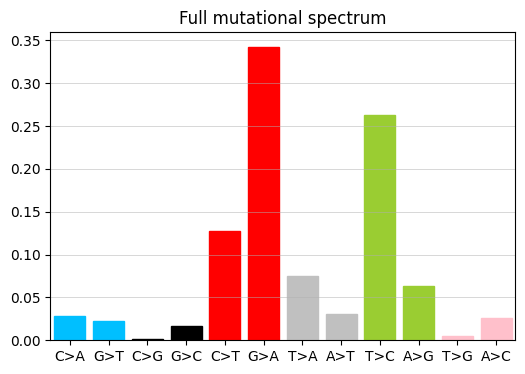

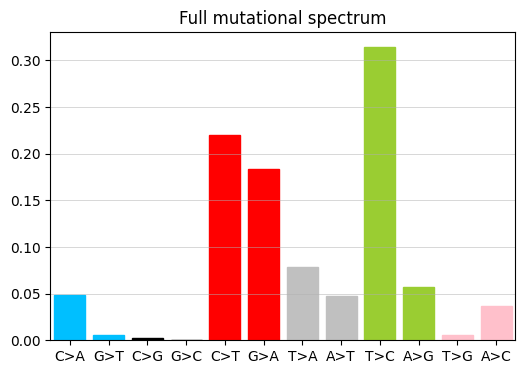

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [5]:
plot_mutspec12(mus_nd1['ms_rec12'])
plot_mutspec12(mus_cytb['ms_rec12'])

## Position Invariativity QC

### Obs mutations

In [5]:
to_concat = []
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    df = data["mutations"].merge(data['rate'], right_on="Site", left_on="PosInGene")
    df['IsTerminal'] = df.AltNode.str.startswith("RN_")
    df["Gene"] = lbl
    to_concat.append(df)
df = pd.concat(to_concat, ignore_index=True)

In [6]:
df

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,Site,Rate,Cat,C_Rate,IsTerminal
0,G[A>G]C,0,4,1,ACC,GCC,T,A,0.999990,0.999990,0.997801,Node4527,Node4528,human_cytb,4,2.80721,5,3.13762,False
1,G[A>G]C,0,4,1,ACC,GCC,T,A,1.000000,1.000000,0.999988,Node4684,RN_4400,human_cytb,4,2.80721,5,3.13762,True
2,G[A>G]C,0,4,1,ACC,GCC,T,A,1.000000,1.000000,0.999995,Node1195,RN_4732,human_cytb,4,2.80721,5,3.13762,True
3,G[G>T]C,0,4,1,GCC,TCC,A,S,0.998070,0.998070,0.998061,Node656,RN_519,human_cytb,4,2.80721,5,3.13762,True
4,G[A>T]C,0,4,1,ACC,TCC,T,S,1.000000,1.000000,0.997854,Node1839,RN_2921,human_cytb,4,2.80721,5,3.13762,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12930,A[C>T]A,1,951,3,TAC,TAT,Y,Y,0.936799,0.038429,0.024074,Node62,Node61,mus_nd1,951,1.67994,4,1.68416,False
12931,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.029581,0.028162,0.017642,Node62,Node61,mus_nd1,951,1.67994,4,1.68416,False
12932,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.029581,0.029581,0.018531,Node62,Node63,mus_nd1,951,1.67994,4,1.68416,False
12933,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.041022,0.040990,0.031178,Node61,Node58,mus_nd1,951,1.67994,4,1.68416,False


In [7]:
x = df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull.sum().reset_index()
x

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cytb,0,Node1024,False,0.995677
1,0,human_cytb,0,Node1050,False,0.997834
2,0,human_cytb,0,Node106,False,0.997877
3,0,human_cytb,0,Node1081,False,0.995564
4,0,human_cytb,0,Node1084,False,0.997819
...,...,...,...,...,...,...
9028,5,mus_nd1,2,RN_78,True,0.967015
9029,5,mus_nd1,2,RN_79,True,0.994136
9030,5,mus_nd1,2,RN_83,True,0.992445
9031,5,mus_nd1,2,RN_84,True,0.999995


In [8]:
x[x.Cat == 0]#.groupby("Gene").ProbaFull.sum()

,Cat,Gene,Label,AltNode,IsTerminal,ProbaFull
0,0,human_cytb,0,Node1024,False,0.995677
1,0,human_cytb,0,Node1050,False,0.997834
2,0,human_cytb,0,Node106,False,0.997877
3,0,human_cytb,0,Node1081,False,0.995564
4,0,human_cytb,0,Node1084,False,0.997819
...,...,...,...,...,...,...
1955,0,mus_nd1,0,RN_77,True,0.987634
1956,0,mus_nd1,0,RN_84,True,0.999995
1957,0,mus_nd1,1,Node59,False,0.739490
1958,0,mus_nd1,1,Node73,False,0.961039


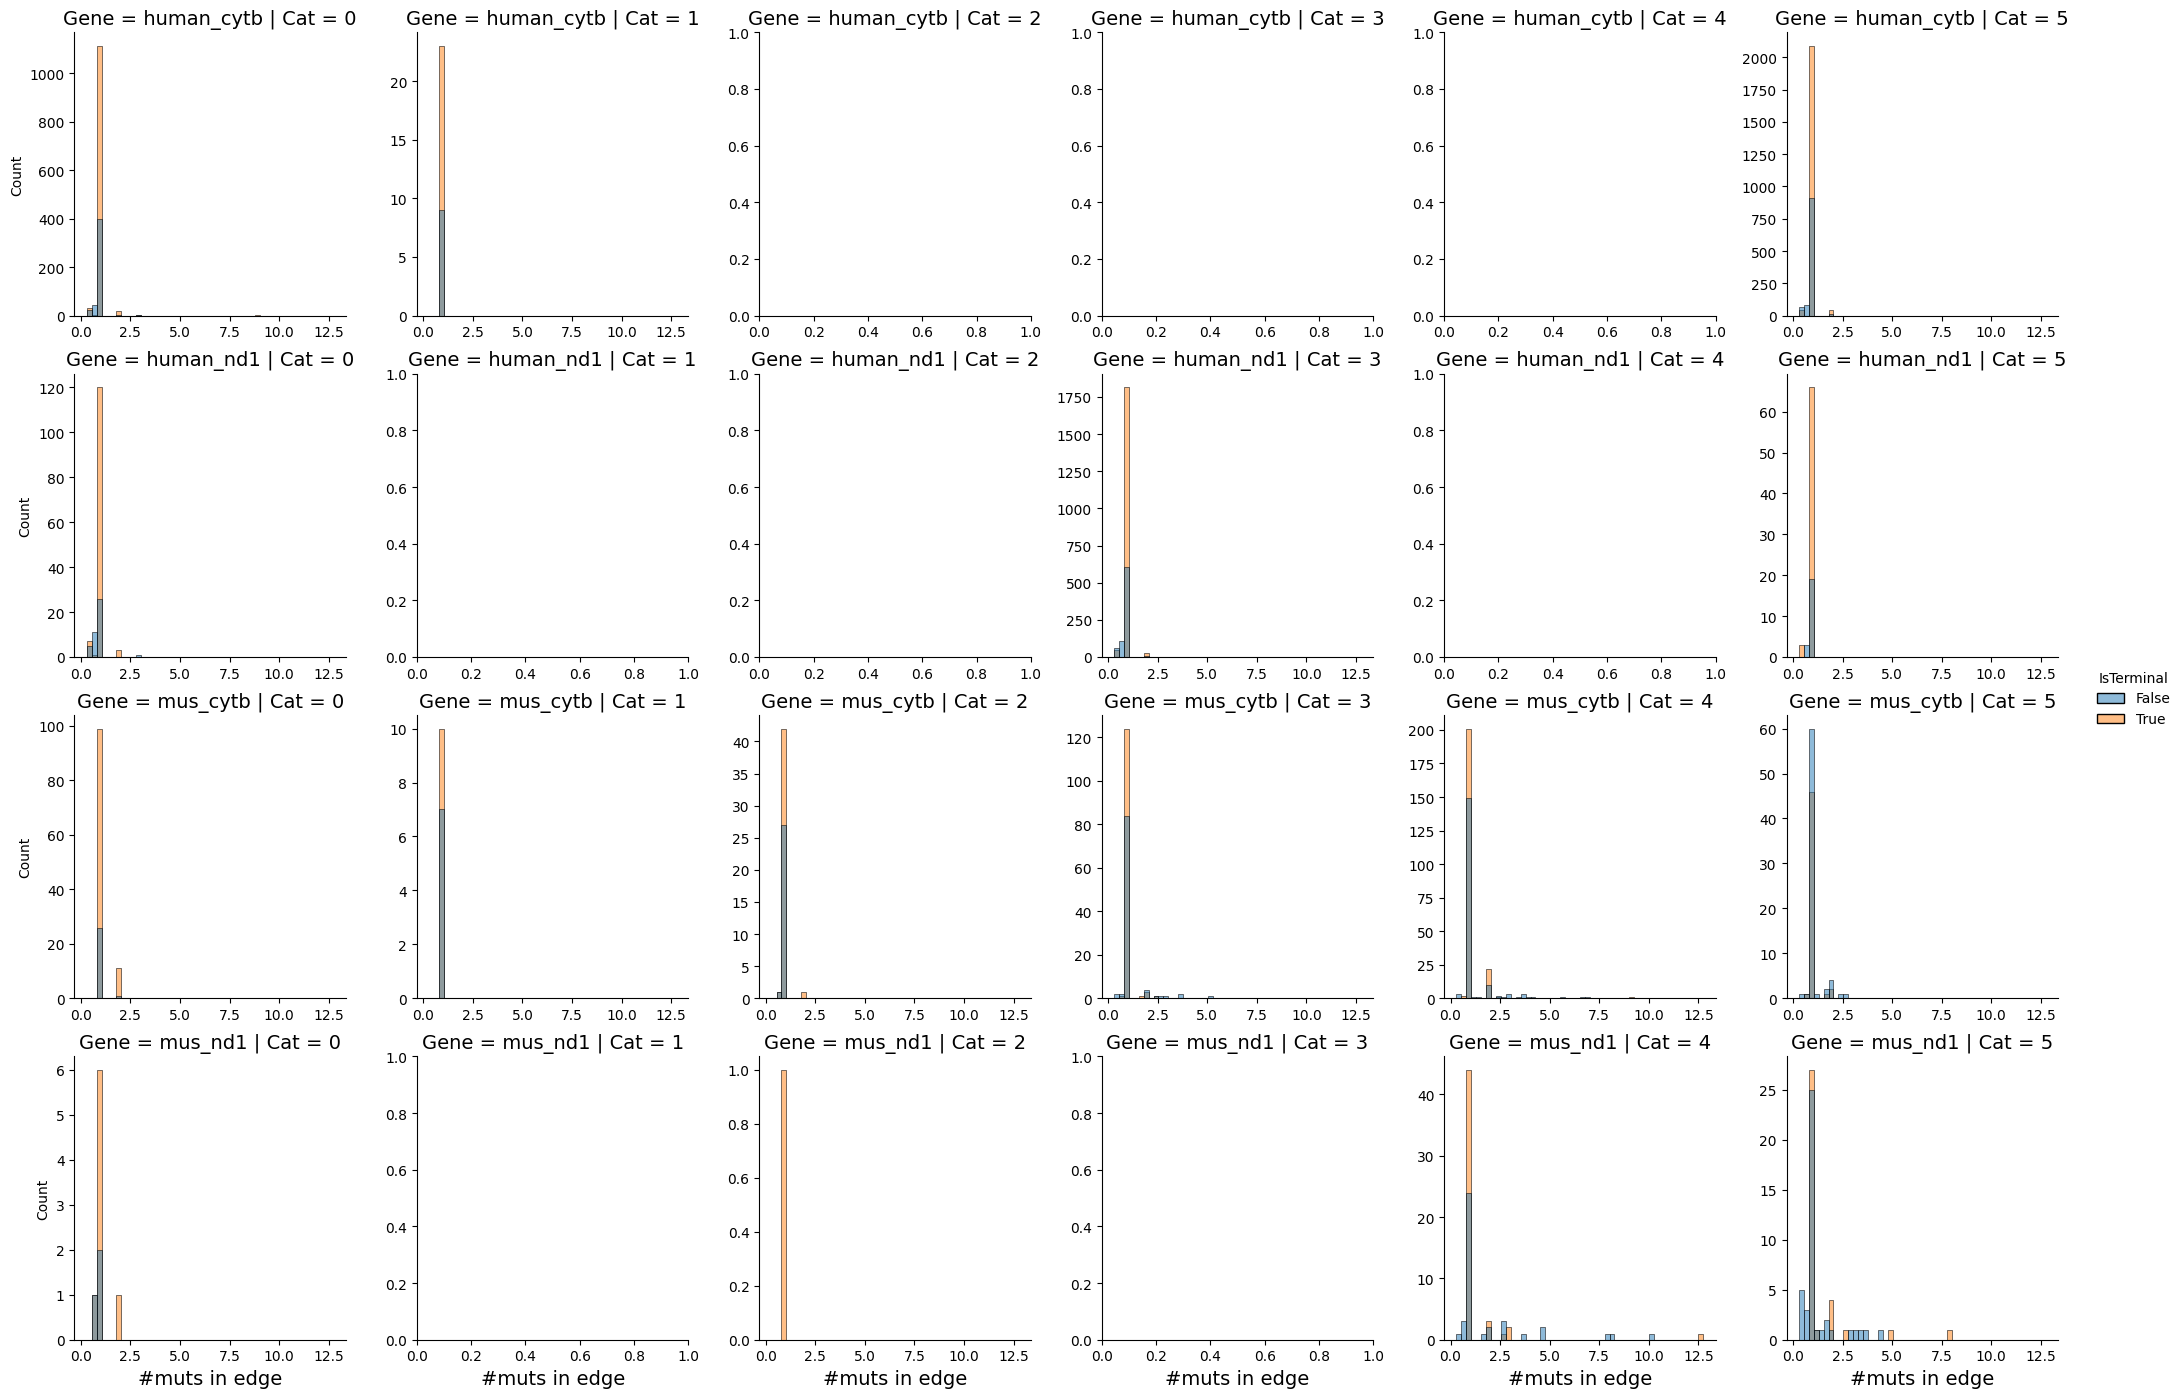

In [21]:
_df_to_plot = df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "AltNode", "IsTerminal"]).ProbaFull\
    .sum().reset_index()

g = sns.displot(
    data=_df_to_plot,
    x="ProbaFull",
    col="Cat",
    row="Gene",
    hue="IsTerminal",
    # kind="hist",
    height=3.5,
    bins=50,
    facet_kws=dict(
        sharey=False,
        sharex=False,
    )
)
g.set_axis_labels("#muts in edge", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

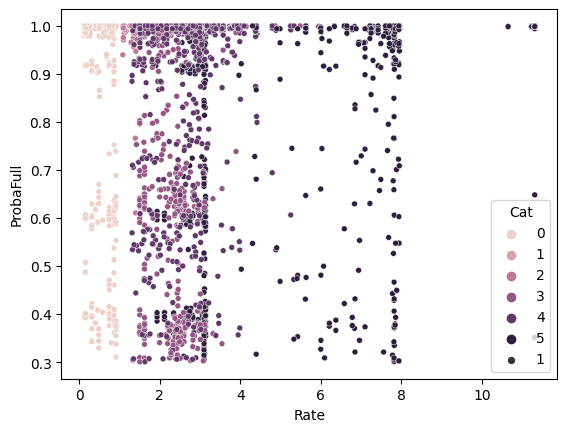

In [10]:
sns.scatterplot(data=df[df.ProbaFull > 0.3], x="Rate", y="ProbaFull", hue="Cat", size=1)
plt.show()

In [23]:
df

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,Site,Rate,Cat,C_Rate,IsTerminal
0,G[A>G]C,0,4,1,ACC,GCC,T,A,0.999990,0.999990,0.997801,Node4527,Node4528,human_cytb,4,2.80721,5,3.13762,False
1,G[A>G]C,0,4,1,ACC,GCC,T,A,1.000000,1.000000,0.999988,Node4684,RN_4400,human_cytb,4,2.80721,5,3.13762,True
2,G[A>G]C,0,4,1,ACC,GCC,T,A,1.000000,1.000000,0.999995,Node1195,RN_4732,human_cytb,4,2.80721,5,3.13762,True
3,G[G>T]C,0,4,1,GCC,TCC,A,S,0.998070,0.998070,0.998061,Node656,RN_519,human_cytb,4,2.80721,5,3.13762,True
4,G[A>T]C,0,4,1,ACC,TCC,T,S,1.000000,1.000000,0.997854,Node1839,RN_2921,human_cytb,4,2.80721,5,3.13762,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12930,A[C>T]A,1,951,3,TAC,TAT,Y,Y,0.936799,0.038429,0.024074,Node62,Node61,mus_nd1,951,1.67994,4,1.68416,False
12931,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.029581,0.028162,0.017642,Node62,Node61,mus_nd1,951,1.67994,4,1.68416,False
12932,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.029581,0.029581,0.018531,Node62,Node63,mus_nd1,951,1.67994,4,1.68416,False
12933,A[T>C]A,1,951,3,TAT,TAC,Y,Y,0.041022,0.040990,0.031178,Node61,Node58,mus_nd1,951,1.67994,4,1.68416,False


In [29]:
site_muts = df[df.ProbaFull > 0.3].groupby(["Gene", "Site", "Rate", "Cat"]).ProbaFull.sum().rename("NMuts").reset_index()
site_muts.head()

,Gene,Site,Rate,Cat,NMuts
0,human_cytb,4,2.80721,5,13.978406
1,human_cytb,5,0.74763,0,8.982526
2,human_cytb,6,0.74763,0,1.731602
3,human_cytb,7,2.81060,5,1.995669
4,human_cytb,9,3.13597,5,15.968100


<AxesSubplot:>

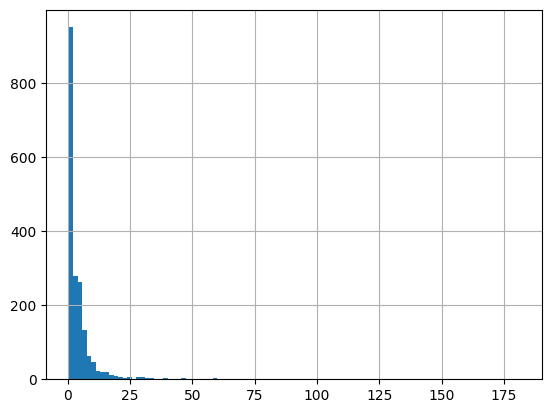

In [34]:
site_muts.NMuts.hist(bins=100)

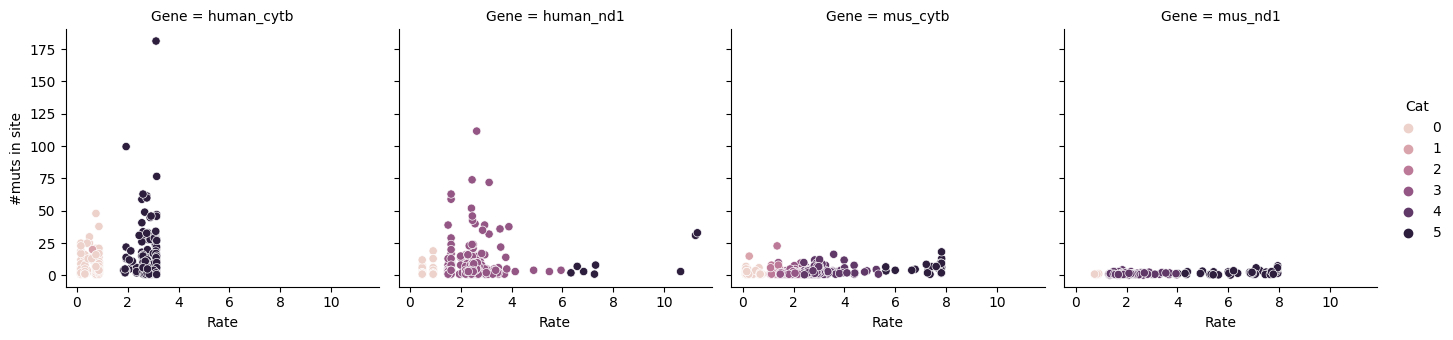

In [56]:
sns.relplot(data=site_muts, x="Rate", y="NMuts", hue="Cat",  col="Gene", sizes=(0, 160), height=3.5).set_axis_labels("Rate", "#muts in site")

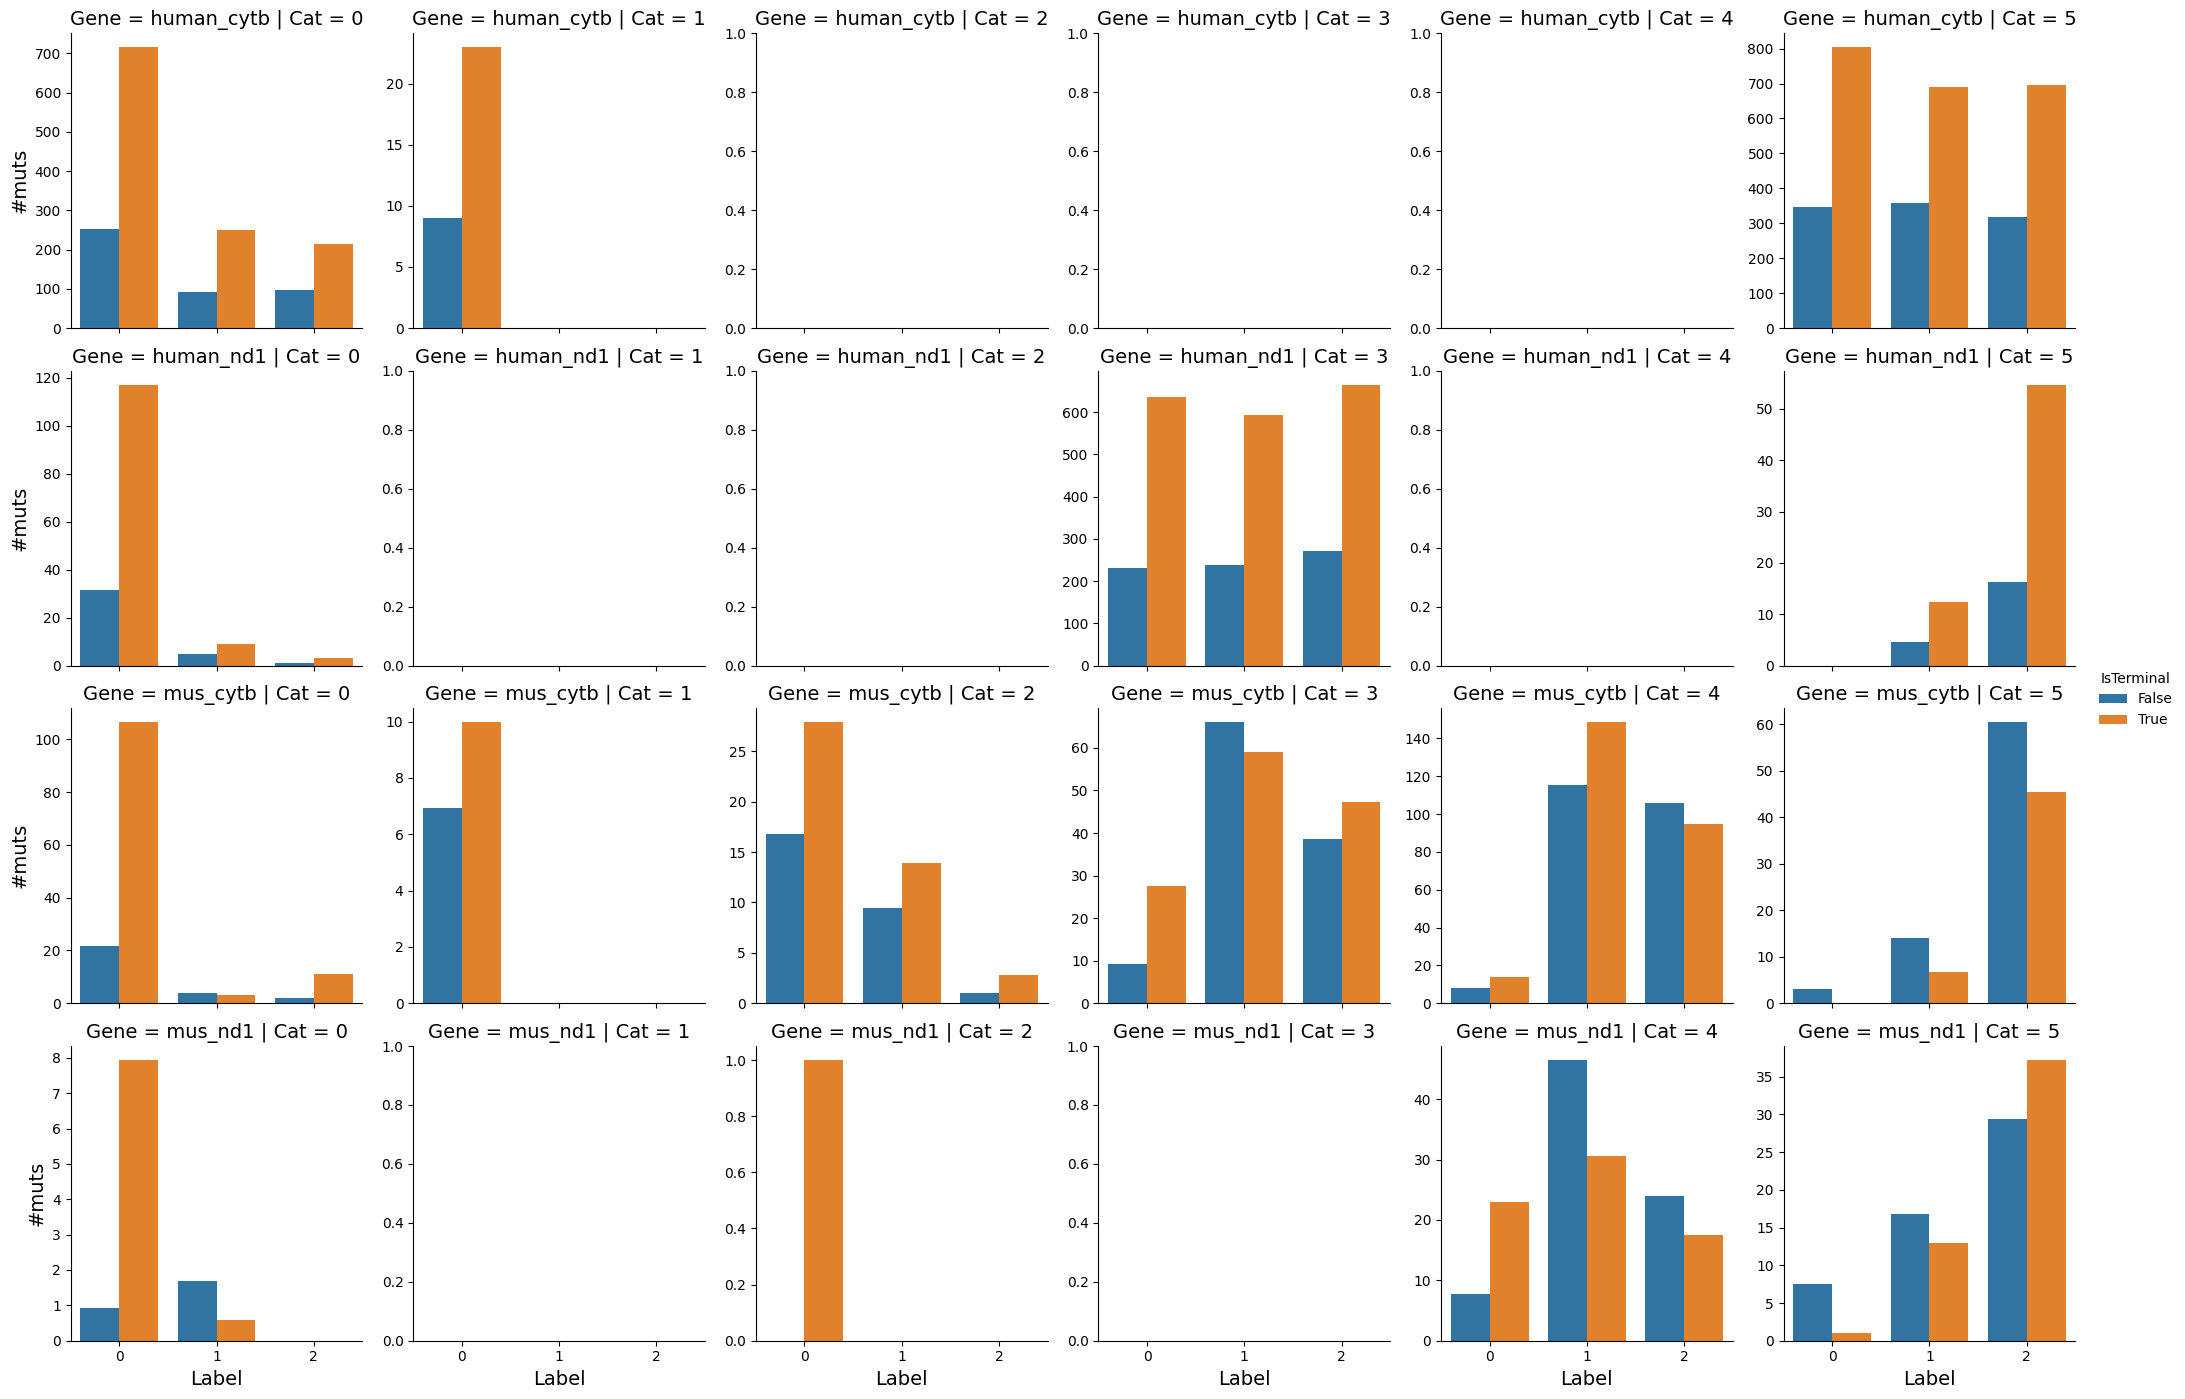

In [57]:
g = sns.catplot(
    data=df[(df.ProbaFull > 0.3)].groupby(["Cat", "Gene", "Label", "IsTerminal"]).ProbaFull.sum().reset_index(),
    x="Label",
    y="ProbaFull",
    hue="IsTerminal",
    col="Cat",
    row="Gene",
    kind="bar",
    height=3.5,
    sharey=False,
)
g.set_axis_labels("Label", "#muts", size=14)
g.set_titles(size=14)
# plt.savefig("../figures/obs_muts_in_cats.pdf")
plt.show()

### ALN

In [5]:
def get_variability_rate(aln):
    seq = []
    n = len(aln)
    for column in zip(*aln):
        m = Counter(column).most_common()[0][1]
        seq.append(m / n)
    return seq

In [ ]:
## Check 0 category of rates (it must be invariant)
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    cats = data['rate']['Cat'].values
    vrate = get_variability_rate(data['aln'])
    print(lbl)
    assert len(cats) == len(vrate)
    for site,(c, vr) in enumerate(zip(cats, vrate), 1):
        if c == 0 and vr != 1 or c != 0 and vr == 1:
            print(f"cat = {c}, vrate = {vr:.2f} on site {site}")
    
    print()

## check strand in image

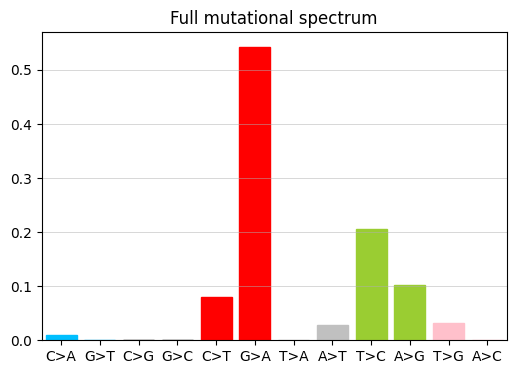

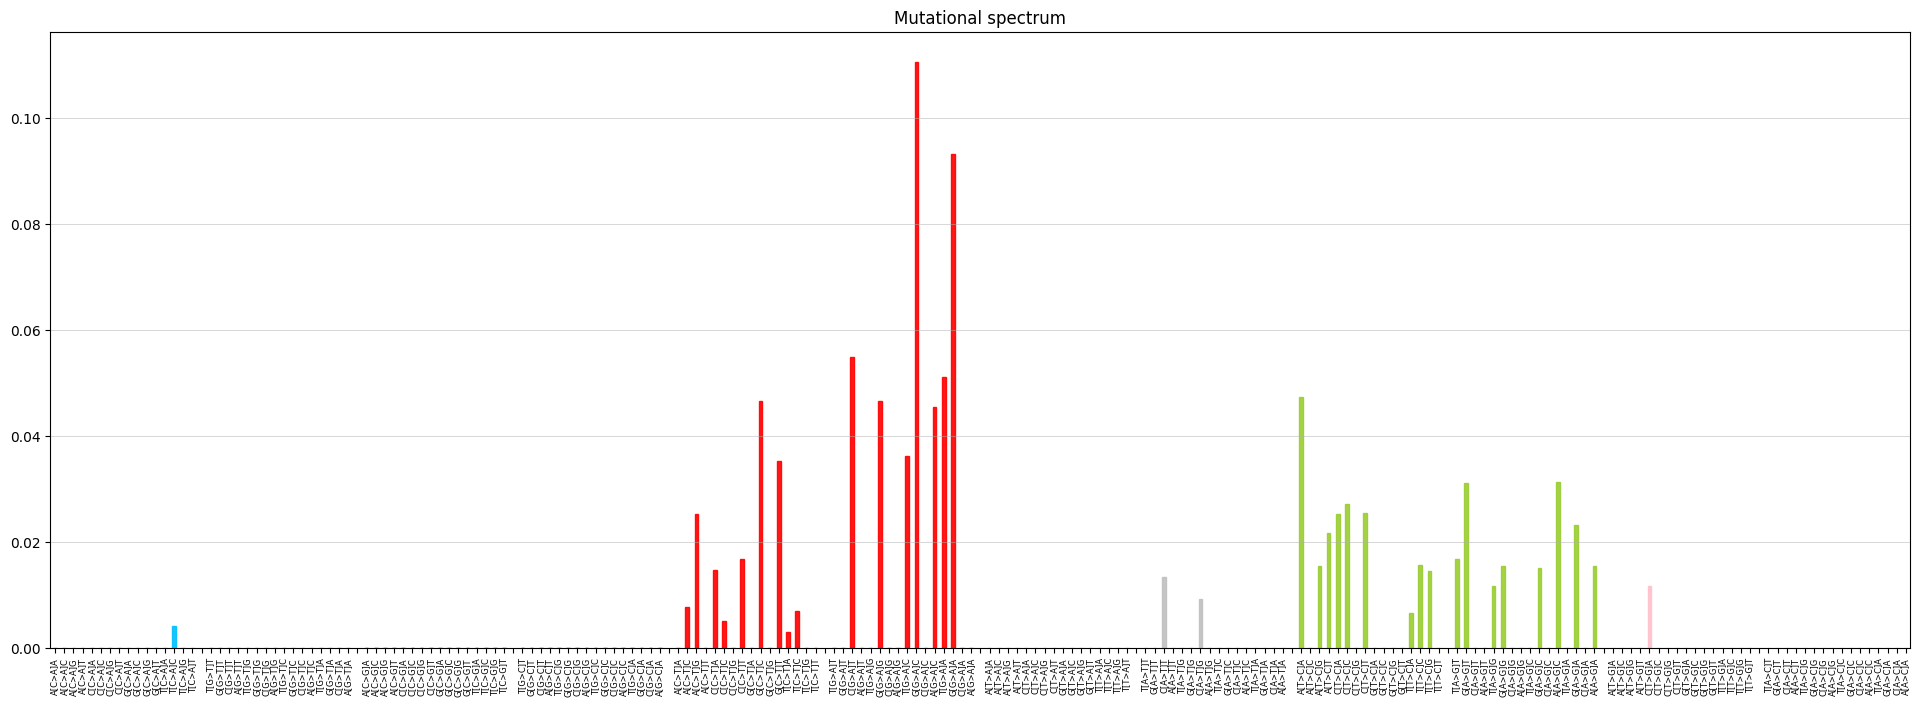

In [35]:
plot_mutspec12(human_cytb["ms_rec12"])
plot_mutspec192(human_cytb["ms_rec192"])

**light**

## Estimate mutations under selection

In [7]:
def count_diff(df):
    nzeros = (df.ObsNum_sim == 0).sum()
    nplus = ((df.ObsNum_rec.round() > df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    nminus = ((df.ObsNum_rec.round() < df.ObsNum_sim) & (df.ObsNum_sim != 0)).sum()
    n = nzeros + nplus + nminus
    n_eq = 200 - n
    return pd.Series(dict(nzeros=nzeros, n_eq=n_eq, nplus=nplus, nminus=nminus, zerosFr=nzeros/n, plusFr=nplus/n, minusFr=nminus/n))


def get_significance(df):
    a = df.nplus.item()
    b = df.nminus.item()
    n = a + b
    if n > 5:
        pval = binom_test(a, n)
    else:
        pval = np.nan
    return pval

In [8]:
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    # drop low-proba mutations from ObsNum (simple replacing)
    pcutoff = 0.3
    _ms_rec192 = data["ms_rec192"].copy()
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()
    _ms_rec192["ObsNum"] = _ms_rec192["Mut"].map(high_proba_obs).fillna(0.)

    # merge rec and sim
    df = _ms_rec192.merge(data["ms_sim192"], on="Mut", suffixes=["_rec", "_sim"])
    # df["diff"] = df["ObsNum_rec"] - df["ObsNum_sim"]
    data["both"] = df
    gr = df.groupby("Mut")
    
    diff_stats = gr.agg({"ObsNum_rec": "mean", "ObsNum_sim": "mean"})

    # diff_stats = gr["diff"].agg(
    #     ["mean", "std", lambda x: bootstrap((x,), np.mean).confidence_interval])
    # diff_stats["low"] = diff_stats["<lambda_0>"].apply(lambda x: x.low)
    # diff_stats["high"] = diff_stats["<lambda_0>"].apply(lambda x: x.high)
    # diff_stats.drop("<lambda_0>", axis=1, inplace=True)
    
    _diff_stats2 = gr.apply(count_diff)
    diff_stats = diff_stats.merge(_diff_stats2, left_index=True, right_index=True)
    del _diff_stats2
    diff_stats["p-value"] = diff_stats["n_eq"] / 201
    # diff_stats["p-value"] = diff_stats.apply(get_significance, axis=1)
    # diff_stats["p-value-adj"] = multipletests(diff_stats["p-value"])[1]

    data["diff_stats"] = diff_stats

    # extract sbs under selection
    pval_cutoff = 0.15 if lbl.startswith("human") else 0.05
    diff_stats_filtered = diff_stats[(diff_stats["ObsNum_rec"] > 0) & (diff_stats["p-value"] < pval_cutoff) & (diff_stats["zerosFr"] < 0.95)]
    data["diff_stats_filtered"] = diff_stats_filtered
    data["muts_positive"] = diff_stats_filtered[(diff_stats_filtered["nplus"] > diff_stats_filtered["nminus"])].index.values
    data["muts_negative"] = diff_stats_filtered[(diff_stats_filtered["nplus"] < diff_stats_filtered["nminus"])].index.values


In [9]:
human_cytb["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
T[G>A]C,1.7183,0.537688,118.0,21.0,58.0,3.0,0.659218,0.324022,0.01676,0.104478


In [10]:
human_nd1["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]C,3.715822,0.190955,165.0,1.0,34.0,0.0,0.829146,0.170854,0.000000,0.004975
T[C>T]A,1.857348,0.276382,150.0,7.0,43.0,0.0,0.777202,0.222798,0.000000,0.034826
T[G>A]C,1.856944,0.261307,155.0,7.0,37.0,1.0,0.803109,0.191710,0.005181,0.034826


In [11]:
mus_nd1["diff_stats_filtered"].sort_values("Mut")

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[A>G]T,1.692011,0.360,134.0,6.0,60.0,0.0,0.690722,0.309278,0.000000,0.029851
A[C>T]C,1.684218,0.300,153.0,9.0,36.0,2.0,0.801047,0.188482,0.010471,0.044776
A[C>T]G,4.512367,2.305,17.0,5.0,172.0,6.0,0.087179,0.882051,0.030769,0.024876
A[C>T]T,13.980263,7.590,0.0,1.0,196.0,3.0,0.000000,0.984925,0.015075,0.004975
A[T>C]A,5.861638,2.085,24.0,1.0,174.0,1.0,0.120603,0.874372,0.005025,0.004975
A[T>C]G,3.251437,0.925,74.0,8.0,115.0,3.0,0.385417,0.598958,0.015625,0.039801
A[T>C]T,2.462951,8.285,0.0,3.0,0.0,197.0,0.000000,0.000000,1.000000,0.014925
C[A>T]A,3.730200,0.680,106.0,1.0,93.0,0.0,0.532663,0.467337,0.000000,0.004975
C[A>T]T,0.301376,0.690,103.0,0.0,0.0,97.0,0.515000,0.000000,0.485000,0.000000


In [12]:
mus_cytb["diff_stats_filtered"]

,ObsNum_rec,ObsNum_sim,nzeros,n_eq,nplus,nminus,zerosFr,plusFr,minusFr,p-value
Mut,,,,,,,,,,
A[C>T]A,11.726302,4.510,1.0,0.0,199.0,0.0,0.005000,0.995000,0.000000,0.000000
C[A>C]C,0.368183,0.240,159.0,0.0,0.0,41.0,0.795000,0.000000,0.205000,0.000000
C[A>G]G,2.632277,0.300,147.0,1.0,52.0,0.0,0.738693,0.261307,0.000000,0.004975
C[C>T]T,5.054489,10.115,0.0,3.0,7.0,190.0,0.000000,0.035533,0.964467,0.014925
C[T>A]T,0.358066,0.590,114.0,0.0,0.0,86.0,0.570000,0.000000,0.430000,0.000000
C[T>C]C,0.326149,0.345,142.0,0.0,0.0,58.0,0.710000,0.000000,0.290000,0.000000
G[A>G]A,3.074302,0.795,87.0,7.0,105.0,1.0,0.450777,0.544041,0.005181,0.034826
G[A>G]G,5.002764,0.880,78.0,0.0,122.0,0.0,0.390000,0.610000,0.000000,0.000000
G[A>G]T,4.979030,0.220,159.0,0.0,41.0,0.0,0.795000,0.205000,0.000000,0.000000


### Plot sbs under selection

human_cytb


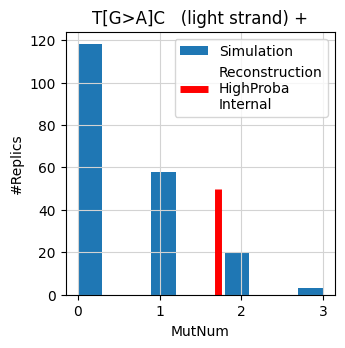

human_nd1


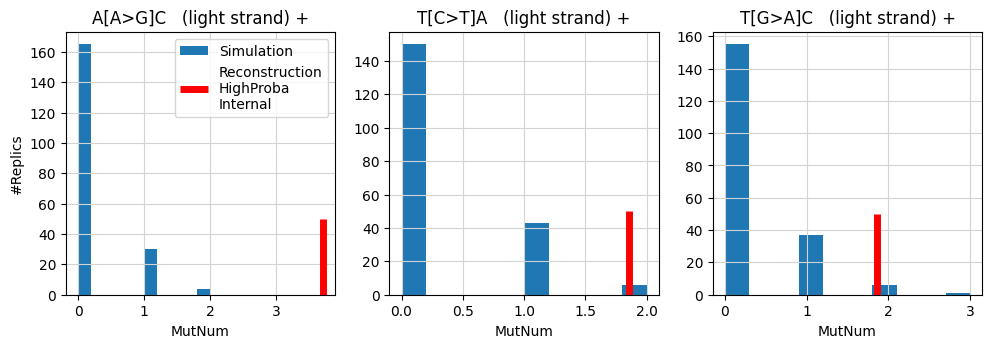

mus_cytb


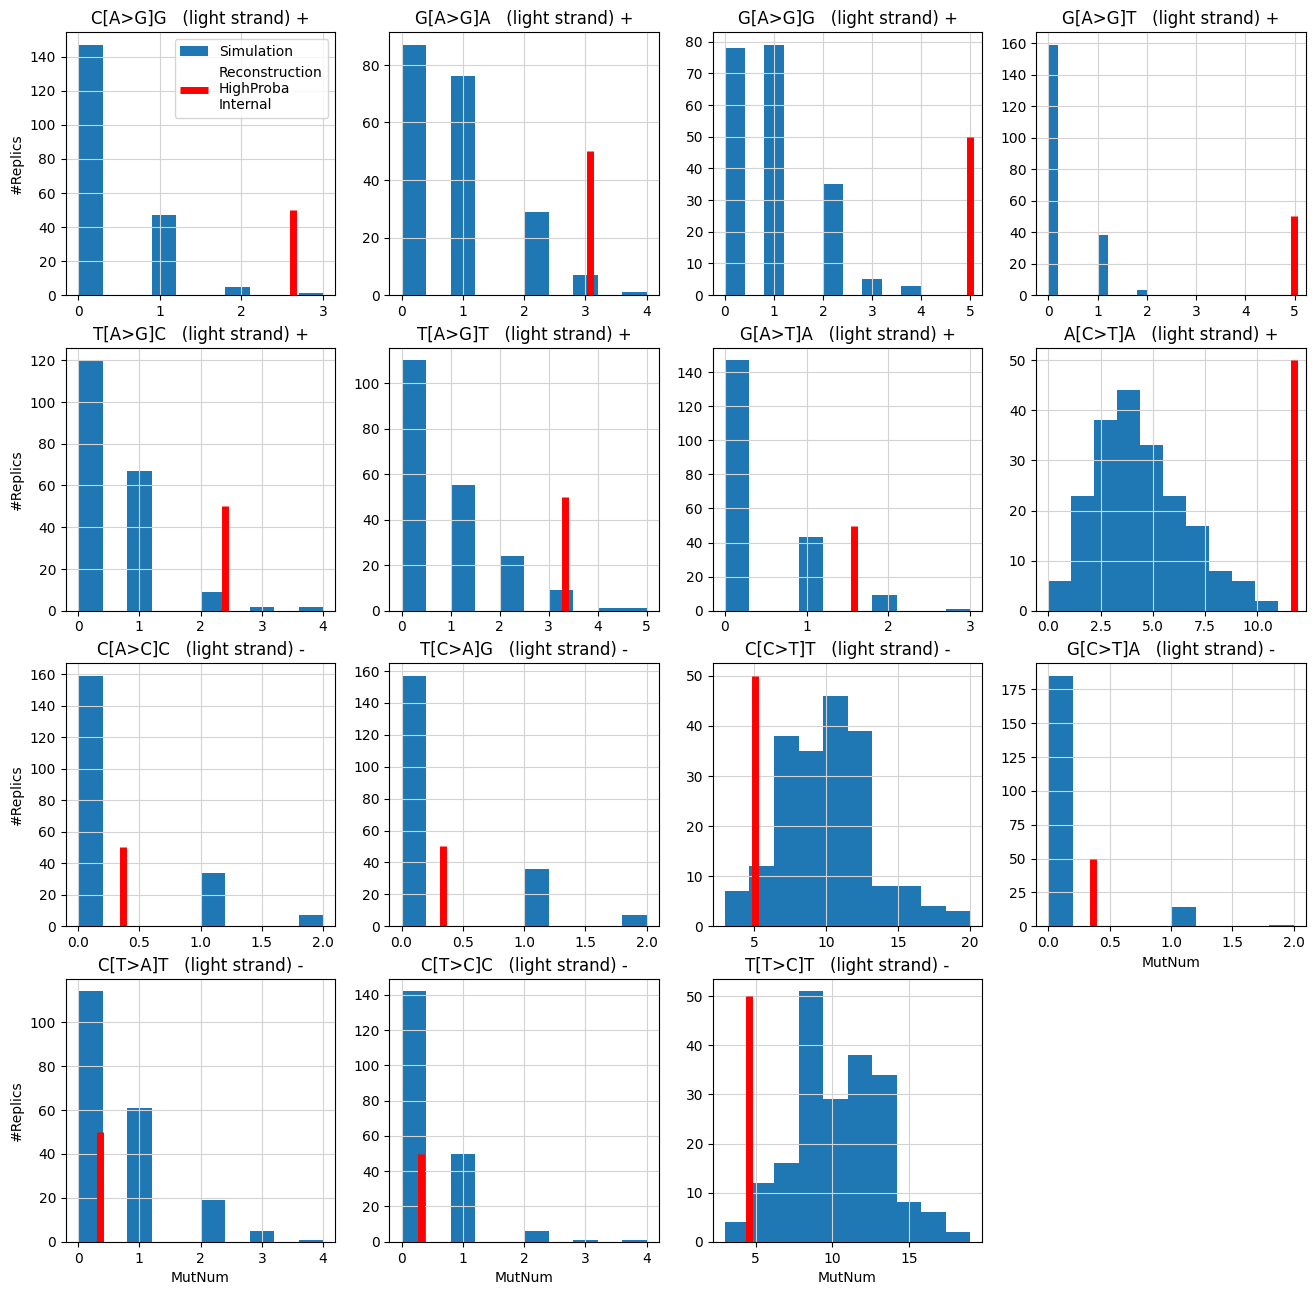

mus_nd1


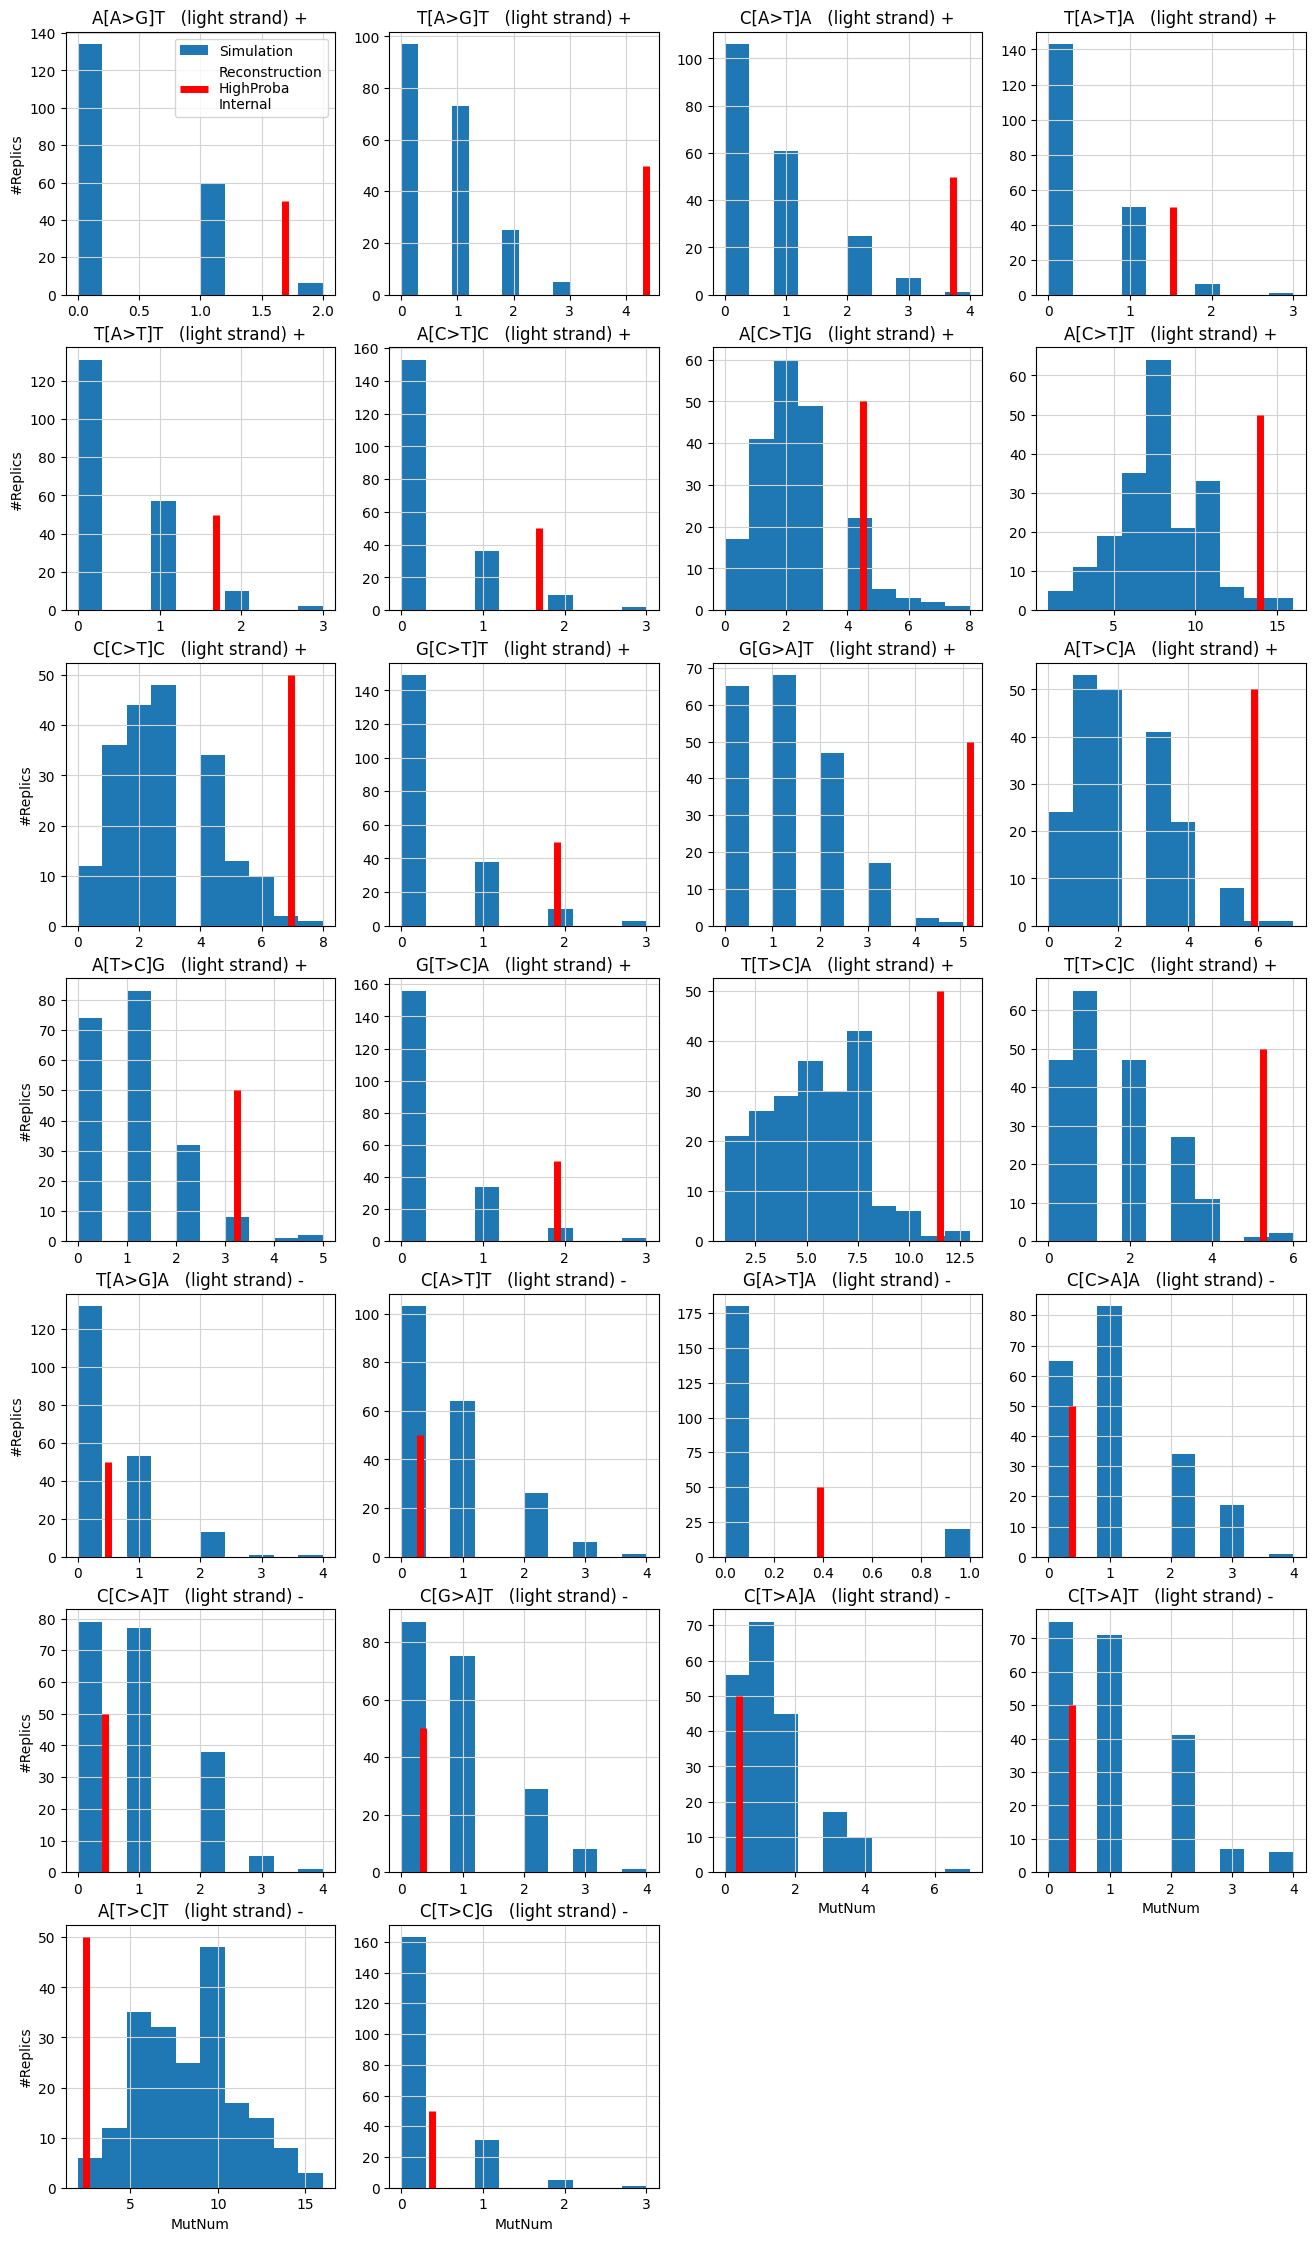

In [13]:
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    print(lbl)
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node"))
    ]
    high_proba_obs = high_proba_muts_syn.groupby("Mut").ProbaFull.sum().to_dict()

    nrows, ncols = 7, 4
    plt.figure(figsize=(ncols*4, nrows*4))
    smuts = [x for x in possible_sbs192 if x in data["muts_positive"]]
    effect = "+"
    for i, sbs in enumerate(smuts, 1):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()
    k = i + 1
    smuts = [x for x in possible_sbs192 if x in data["muts_negative"]]
    effect = "-"
    for i, sbs in enumerate(smuts, k):
        sbs_distro = data["ms_sim192"][data["ms_sim192"].Mut == sbs]
        plt.subplot(nrows, ncols, i)
        plt.grid(color="lightgray")
        sbs_distro.ObsNum.hist(label="Simulation")
        plt.vlines([high_proba_obs[sbs]], 0, 50, "r", linewidth=5, label="Reconstruction\nHighProba\nInternal")
        plt.title(f"{sbs}   (light strand) {effect}")
        if i > len(data["diff_stats_filtered"]) - ncols:
            plt.xlabel("MutNum")
        if i % ncols == 1:
            plt.ylabel("#Replics")
        if i == 1:
            plt.legend()

    plt.savefig(f"../figures/sbs_significant_{lbl}.pdf", bbox_inches='tight')
    plt.show()


In [44]:
# save files for ET
# human_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_cytb_simulated_spectra.csv", index=False)
# human_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/human_nd1_simulated_spectra.csv", index=False)
# mus_cytb["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_cytb_simulated_spectra.csv", index=False)
# mus_nd1["both"].drop(["ObsNum_x","ExpNum_x","ObsNum_y","ExpNum_y"], axis=1).to_csv("../data/exposure/stats/mouse_nd1_simulated_spectra.csv", index=False)

# human_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_cytb_stats.csv")
# human_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/human_nd1_stats.csv")
# mus_cytb["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_cytb_stats.csv")
# mus_nd1["diff_stats"].drop("<lambda_0>", axis=1).to_csv("../data/exposure/stats/mouse_nd1_stats.csv")

In [109]:
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    print(lbl)
    print("muts_positive:", list(data["muts_positive"]))
    print("muts_negative:", list(data["muts_negative"]))
    print()

human_cytb
muts_positive: ['T[G>A]C']
muts_negative: []

human_nd1
muts_positive: ['A[A>G]C', 'T[C>T]A', 'T[G>A]C']
muts_negative: []

mus_cytb
muts_positive: ['A[C>T]A', 'C[A>G]G', 'G[A>G]A', 'G[A>G]G', 'G[A>G]T', 'G[A>T]A', 'T[A>G]C', 'T[A>G]T']
muts_negative: ['C[A>C]C', 'C[C>T]T', 'C[T>A]T', 'C[T>C]C', 'G[C>T]A', 'T[C>A]G', 'T[T>C]T']

mus_nd1
muts_positive: ['A[A>G]T', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'A[T>C]A', 'A[T>C]G', 'C[A>T]A', 'C[C>T]C', 'G[C>T]T', 'G[G>A]T', 'G[T>C]A', 'T[A>G]T', 'T[A>T]A', 'T[A>T]T', 'T[T>C]A', 'T[T>C]C']
muts_negative: ['A[T>C]T', 'C[A>T]T', 'C[C>A]A', 'C[C>A]T', 'C[G>A]T', 'C[T>A]A', 'C[T>A]T', 'C[T>C]G', 'G[A>T]A', 'T[A>G]A']



### impose mutations effect on genome

In [137]:
for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    high_proba_muts_syn = data["mutations"][
        (data["mutations"].ProbaFull > pcutoff) & 
        (data["mutations"].Label > 0) &
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].Mut.isin(list(data["muts_positive"]) + list(data["muts_negative"])))
    ].drop(["ProbaRef", "ProbaMut", "Gene", "AltAa"], axis=1)
    high_proba_muts_syn["Effect"] = high_proba_muts_syn.Mut.map(
        dict(**{x:"+" for x in data["muts_positive"]}, **{x:"-" for x in data["muts_negative"]})
    )
    high_proba_muts_syn.to_csv(f"../data/exposure/position_analysis/observed_mutations_with_effect_{lbl}.csv", index=False)


In [111]:
# fout = open("../data/exposure/consensus_labels_fr_syn2.txt", "w")
# for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
#     fout.write(">"+lbl+"\n")
#     fout.write(data['consensus']+"\n")
#     muts_plus = data["mutations"][data["mutations"].Mut.isin(data["muts_positive"])]
#     muts_minus = data["mutations"][data["mutations"].Mut.isin(data["muts_negative"])]

#     muts_plus_est = muts_plus[muts_plus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()
#     muts_minus_est = muts_minus[muts_minus.Label >= 1].groupby(["Mut", "PosInGene"]).ProbaFull.sum()

#     pos_plus  = set(muts_plus_est[muts_plus_est > 0.5].reset_index().PosInGene.values)
#     pos_minus = set(muts_minus_est[muts_minus_est > 0.5].reset_index().PosInGene.values)

#     for pos in range(1, len(data['consensus'])+1):
#         if pos in pos_plus:
#             fout.write("+")
#         elif pos in pos_minus:
#             fout.write("-")
#         else:
#             fout.write(" ")
#     fout.write("\n\n")

# fout.close()

## Sample syn mutations

### Uniform

In [5]:
coda = CodonAnnotation(2)

In [6]:
def sample_mutations(muts, n):
    positions = np.random.choice(muts.Pos.unique(), n, replace=True)
    muts_sample1 = muts[muts.Pos.isin(positions)].groupby("Pos").sample()
    c = Counter(positions)
    samples_up1 = []
    for pos, k in c.most_common(len(positions)):
        if k > 1:
            d = muts[muts.Pos == pos]
            samples_up1.append(d.sample(k - 1, replace=True))
        else:
            break
    if len(samples_up1):
        muts_sample2 = pd.concat(samples_up1)
        total_samples = pd.concat([muts_sample1, muts_sample2])
    else:
        total_samples = muts_sample1
    assert len(total_samples) == n
    return total_samples

In [7]:
nsamples = 10

for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    n = round(data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ].ProbaFull.sum())
    samples = []
    for i in range(nsamples):
        s = sample_mutations(emuts, n)
        s["Sample"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    # samples_df.to_csv(f"../data/exposure/position_analysis/mut_samples_{lbl}.csv", index=False)

### Non-uniform, spectra-specific sampling

In [37]:
from scipy.stats import multinomial

coda = CodonAnnotation(2)

In [39]:
md = multinomial(100, [0.1, 0.4, 0.3, 0.195, 0.005])
md.rvs(3)

array([[11, 43, 27, 19,  0],
       [ 9, 39, 28, 21,  3],
       [13, 43, 31, 12,  1]])

In [110]:
def sample_sbs_counts(muts, sbs_counts: dict):
    sbs_samples = []
    for sbs, cnt in sbs_counts.items():
        if cnt < 1:
            continue
        cur_muts = muts[muts["MutBase"] == sbs]
        if len(cur_muts):
            s = cur_muts.sample(cnt, replace=True)
            sbs_samples.append(s)

    return pd.concat(sbs_samples)


nsamples = 1000

for lbl, data in zip(['human_cytb', 'human_nd1', 'mus_cytb', 'mus_nd1'], [human_cytb, human_nd1, mus_cytb, mus_nd1]):
    emuts = coda.collect_exp_muts(data["consensus"])
    emuts = emuts[emuts.Pos.isin(data["var_pos"])]
    cur_obs_muts = data["mutations"][
        (data["mutations"].Label > 0) & 
        (data["mutations"].AltNode.str.startswith("Node")) & 
        (data["mutations"].ProbaFull > 0.3)
    ]
    n = round(cur_obs_muts.ProbaFull.sum())
    cur_obs_muts["MutBase"] = cur_obs_muts.Mut.str.slice(2, 5)
    spectra12 = cur_obs_muts.groupby("MutBase").ProbaFull.sum()
    spectra12 = (spectra12 / spectra12.sum()).to_dict()
    spectra12 = {sbs: spectra12.get(sbs, 0.001) for sbs in possible_sbs12}
    spectra12 = {sbs: p / sum(spectra12.values()) for sbs, p in spectra12.items()}

    assert len(spectra12) == 12
    sbs_types, probas = spectra12.keys(), list(spectra12.values())
    md = multinomial(n, probas)
    samples = []
    for i, sbs_counts in enumerate(md.rvs(nsamples)):
        sbs_counts = dict(zip(sbs_types, sbs_counts))
        s = sample_sbs_counts(emuts, sbs_counts)
        s["Sample"] = i + 1
        samples.append(s)
    samples_df = pd.concat(samples)
    data["samples"] = samples_df
    samples_df.to_csv(f"../data/exposure/position_analysis/mut_samples_spectra_based_{lbl}.csv", index=False)
    # break

## Stuff - std bars

In [5]:
human_nd1["ms_rec12"] = pd.read_csv("../data/exposure/human_nd1/ms/ms12syn_human_nd1.tsv", sep="\t")
human_nd1["ms_sim12"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms12syn_human_nd1_simulated.tsv", sep="\t")

human_nd1["ms_rec192"] = pd.read_csv("../data/exposure/human_nd1/ms/ms192syn_human_nd1.tsv", sep="\t")
human_nd1["ms_sim192"] = pd.read_csv("../data/exposure/human_nd1/pyvolve/out/ms192syn_human_nd1_simulated.tsv", sep="\t")


In [3]:
from pymutspec.draw import plot_mutspec12, plot_mutspec192

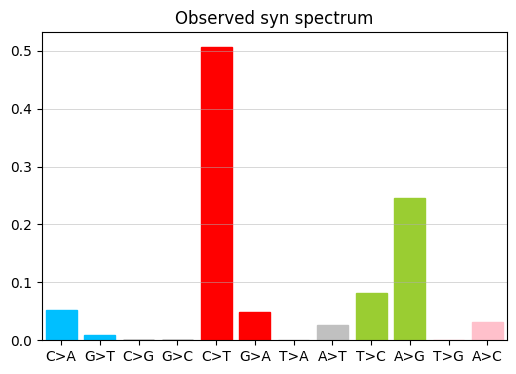

<AxesSubplot:title={'center':'Observed syn spectrum'}>

In [14]:
plot_mutspec12(human_nd1["ms_rec12"], title="Observed syn spectrum",)

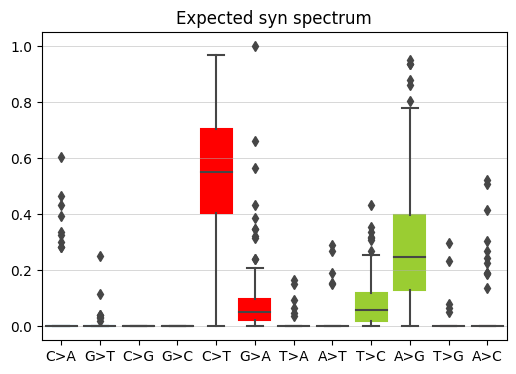

<AxesSubplot:title={'center':'Expected syn spectrum'}>

In [15]:
plot_mutspec12(human_nd1["ms_sim12"], title="Expected syn spectrum", style="box")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


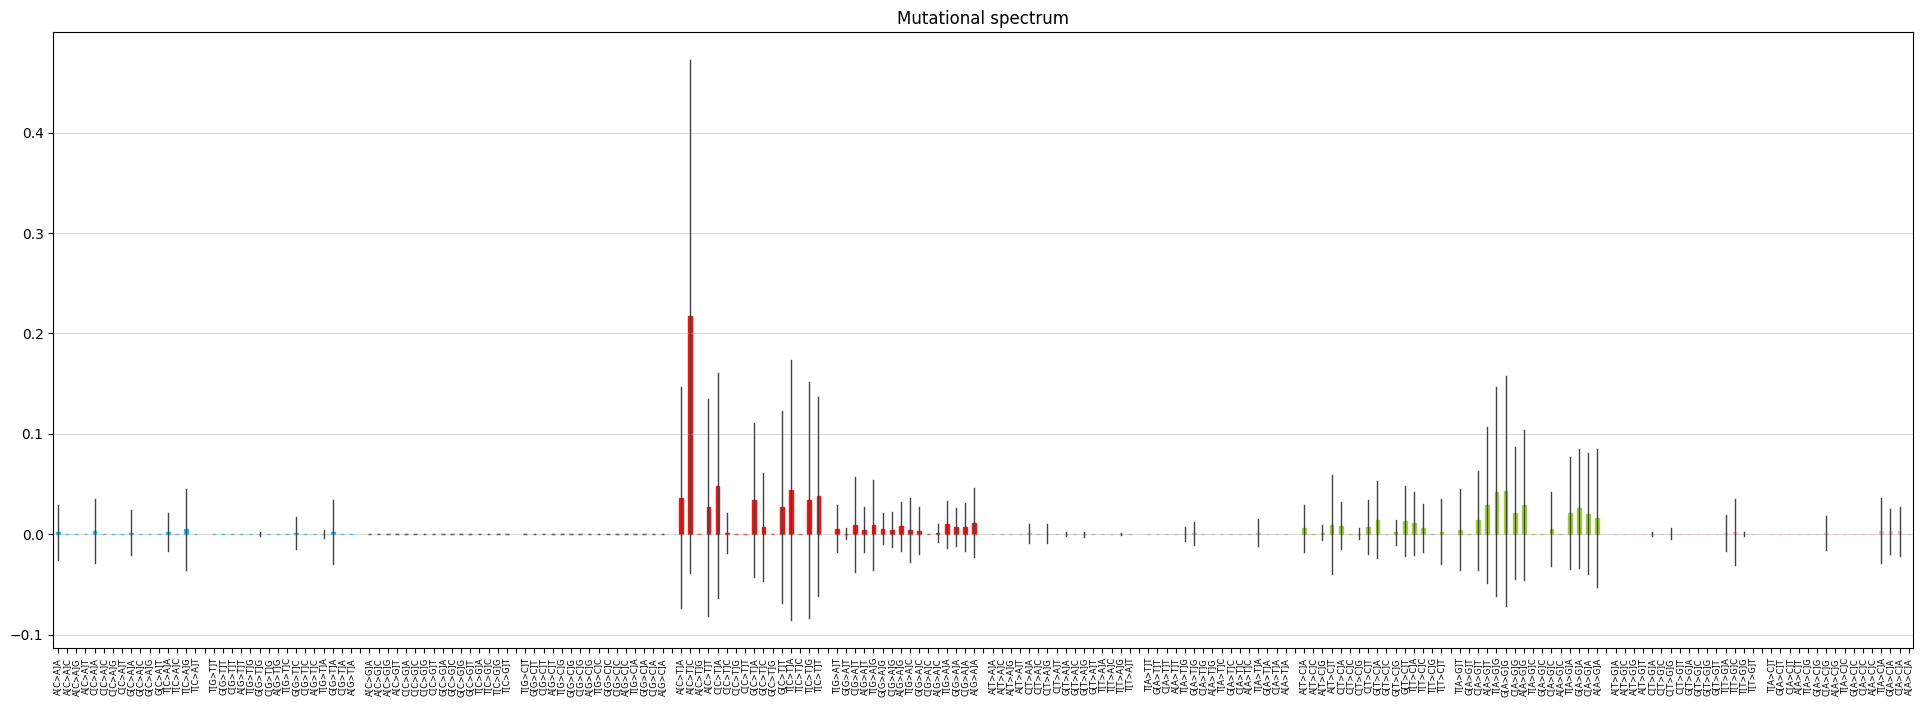

In [6]:
plot_mutspec192(human_nd1["ms_sim192"], ci="sd")

<AxesSubplot:xlabel='Mut', ylabel='MutSpec'>

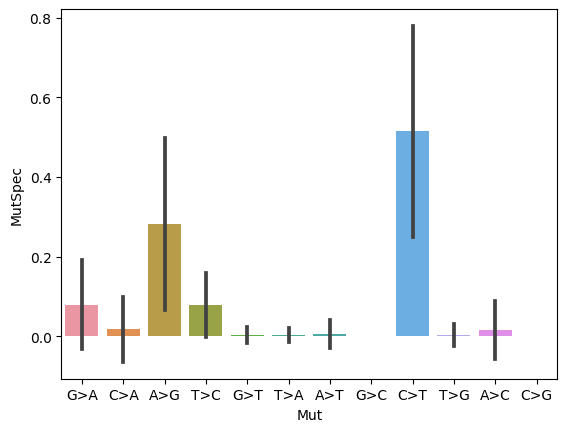

In [7]:
sns.barplot(data=human_nd1["ms_sim12"], x="Mut", y="MutSpec", ci='sd')